# Regression using PyCaret
This was an attempt in Dec 2020 to explore and get familiarised with [PyCaret](https://pycaret.org/), a low-code machine learning library in Python that automates machine learning workflows.  

### Problem Statement
Predict Rating of apps in Google Play Store based on available descriptive app data.

### Data Source
[Public dataset](https://www.kaggle.com/lava18/google-play-store-apps) from Kaggle, thanks to Lavanya Gupta for scraping the data and making them available.
There are 2 datasets, one on app data (category, size, no. of installations, etc) while the other one is a collection of reviews (text data) associated to a subset of the Apps in the app data. This notebook focuses on the former, app data.

In [1]:
# import libraries
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
from datetime import datetime

In [2]:
# read in statistics dataset from Google Play Store
statData_0 = pd.read_csv('googleplaystore.csv')
print(statData_0.shape)
statData_0.head()

(10841, 13)


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [3]:
# begin pandas profiling on statData, comment out after report is generated and saved locally
# statProfile = ProfileReport(statDataset, title='Pandas Profiling Report on Stats Data - final')
# statProfile.to_file('Pandas Profiling Report on Stats Data - final.html')
# statProfile_1.to_notebook_iframe()

In [4]:
# # read in Reviews dataset
# textData_0 = pd.read_csv('googleplaystore_user_reviews.csv')
# print(textData_0.shape)
# textData_0.head()

### Part 1: Data Cleaning

In [5]:
# drop 483 duplicated rows (based on all columns)
statData_1 = statData_0.drop_duplicates().reset_index(drop=True)
statData_1.shape

(10358, 13)

In [6]:
# target variable Rating has 1465 missing values and 1 outlier of 19.0
# remove the missing values and outlier from dataset
statData_1 = statData_1.dropna(subset=['Rating'])
statData_1 = statData_1[statData_1.Rating != 19.0]
statData_1 = statData_1[statData_1['Content Rating'] != 'Unrated']
statData_1.shape

(8891, 13)

In [7]:
# ensure data type is correct for variables Reviews, Price and Last Updated (from object to numerical)
statData_1.loc[:, 'Reviews'] = statData_1.Reviews.astype(int)

statData_1.loc[:, 'Price'] = statData_1['Price'].apply(lambda x: str(x).replace('$', '') if '$' in str(x) else str(x))
statData_1.loc[:, 'Price'] = statData_1['Price'].apply(lambda x: float(x))

statData_1.loc[:, 'Last Updated'] = statData_1['Last Updated'].astype(str)
statData_1.loc[:, 'Last Updated'] = statData_1['Last Updated'].apply(lambda x: datetime.strptime(x, '%B %d, %Y'))

print(statData_1.dtypes)
statData_1.head()

App                       object
Category                  object
Rating                   float64
Reviews                    int32
Size                      object
Installs                  object
Type                      object
Price                    float64
Content Rating            object
Genres                    object
Last Updated      datetime64[ns]
Current Ver               object
Android Ver               object
dtype: object


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0.0,Everyone,Art & Design,2018-01-07,1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0.0,Everyone,Art & Design;Pretend Play,2018-01-15,2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0.0,Everyone,Art & Design,2018-08-01,1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0.0,Teen,Art & Design,2018-06-08,Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0.0,Everyone,Art & Design;Creativity,2018-06-20,1.1,4.4 and up


In [8]:
# examine dataset with duplicated App (this variable should be unique, otherwise we are duplicating training data)
# there are 696 duplicated rows in variable App. remove duplicates by keeping the row with highest number of ratings

statData_1 = statData_1.sort_values(by=['App', 'Reviews'], ascending=[1, 0])
statData_1[statData_1.App == '8 Ball Pool']

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
1654,8 Ball Pool,GAME,4.5,14201891,52M,"100,000,000+",Free,0.0,Everyone,Sports,2018-07-31,4.0.0,4.0.3 and up
1744,8 Ball Pool,GAME,4.5,14201604,52M,"100,000,000+",Free,0.0,Everyone,Sports,2018-07-31,4.0.0,4.0.3 and up
1628,8 Ball Pool,GAME,4.5,14200550,52M,"100,000,000+",Free,0.0,Everyone,Sports,2018-07-31,4.0.0,4.0.3 and up
1544,8 Ball Pool,GAME,4.5,14200344,52M,"100,000,000+",Free,0.0,Everyone,Sports,2018-07-31,4.0.0,4.0.3 and up
1496,8 Ball Pool,GAME,4.5,14198602,52M,"100,000,000+",Free,0.0,Everyone,Sports,2018-07-31,4.0.0,4.0.3 and up
1468,8 Ball Pool,GAME,4.5,14198297,52M,"100,000,000+",Free,0.0,Everyone,Sports,2018-07-31,4.0.0,4.0.3 and up
3508,8 Ball Pool,SPORTS,4.5,14184910,52M,"100,000,000+",Free,0.0,Everyone,Sports,2018-07-31,4.0.0,4.0.3 and up


In [9]:
statData_1 = statData_1.drop_duplicates(subset=['App']).reset_index(drop=True)
print(statData_1.shape)
# check that the data row with highest no. of ratings is kept for duplicated apps
statData_1[statData_1.App == '8 Ball Pool']

(8195, 13)


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
91,8 Ball Pool,GAME,4.5,14201891,52M,"100,000,000+",Free,0.0,Everyone,Sports,2018-07-31,4.0.0,4.0.3 and up


### Part 2: Feature Engineering

In [10]:
# convert Size and Installs into continuous variable (create new columns)
## remove + sign from Installs
statData_1['Installs_num'] = statData_1['Installs'].apply(lambda x: x.replace('+', '') if '+' in str(x) else x)
statData_1['Installs_num'] = statData_1['Installs_num'].apply(lambda x: x.replace(',', '') if ',' in str(x) else x)
statData_1['Installs_num'] = statData_1['Installs_num'].apply(lambda x: int(x))
print(statData_1.shape)
statData_1.head()

(8195, 14)


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Installs_num
0,+Download 4 Instagram Twitter,SOCIAL,4.5,40467,22M,"1,000,000+",Free,0.0,Everyone,Social,2018-08-02,5.03,4.1 and up,1000000
1,- Free Comics - Comic Apps,COMICS,3.5,115,9.1M,"10,000+",Free,0.0,Mature 17+,Comics,2018-07-13,5.0.12,5.0 and up,10000
2,.R,TOOLS,4.5,259,203k,"10,000+",Free,0.0,Everyone,Tools,2014-09-16,1.1.06,1.5 and up,10000
3,/u/app,COMMUNICATION,4.7,573,53M,"10,000+",Free,0.0,Mature 17+,Communication,2018-07-03,4.2.4,4.1 and up,10000
4,058.ba,NEWS_AND_MAGAZINES,4.4,27,14M,100+,Free,0.0,Everyone,News & Magazines,2018-07-06,1.0,4.2 and up,100


In [11]:
## remove k and M sign from Size
statData_1['Size_num'] = statData_1['Size'].apply(lambda x: str(x).replace('Varies with device', '999') 
                                                  if 'Varies with device' in str(x) else x)
statData_1['Size_num'] = statData_1['Size_num'].apply(lambda x: str(x).replace('M', '') if 'M' in str(x) else x)
statData_1['Size_num'] = statData_1['Size_num'].apply(lambda x: str(x).replace(',', '') if 'M' in str(x) else x)
statData_1['Size_num'] = statData_1['Size_num'].apply(lambda x: float(str(x).replace('k', '')) / 1000 
                                                      if 'k' in str(x) else x)
statData_1['Size_num'] = statData_1['Size_num'].apply(lambda x: float(x))

print(statData_1.shape)
statData_1.head()

(8195, 15)


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Installs_num,Size_num
0,+Download 4 Instagram Twitter,SOCIAL,4.5,40467,22M,"1,000,000+",Free,0.0,Everyone,Social,2018-08-02,5.03,4.1 and up,1000000,22.000
1,- Free Comics - Comic Apps,COMICS,3.5,115,9.1M,"10,000+",Free,0.0,Mature 17+,Comics,2018-07-13,5.0.12,5.0 and up,10000,9.100
2,.R,TOOLS,4.5,259,203k,"10,000+",Free,0.0,Everyone,Tools,2014-09-16,1.1.06,1.5 and up,10000,0.203
3,/u/app,COMMUNICATION,4.7,573,53M,"10,000+",Free,0.0,Mature 17+,Communication,2018-07-03,4.2.4,4.1 and up,10000,53.000
4,058.ba,NEWS_AND_MAGAZINES,4.4,27,14M,100+,Free,0.0,Everyone,News & Magazines,2018-07-06,1.0,4.2 and up,100,14.000


In [12]:
# check range of Size_num
statData_1[statData_1.Size_num != 999].Size_num.describe()

count    7025.000000
mean       21.760621
std        22.728496
min         0.008500
25%         4.900000
50%        13.000000
75%        31.000000
max       100.000000
Name: Size_num, dtype: float64

In [13]:
# Bin Size variable
statData_1['Size_bin'] = pd.cut(statData_1.Size_num, bins=[0, 1.0, 10.0, 30.0, 50.0, 100.0, 999.0], 
                                labels=['<= 1MB', '<= 10MB', '<= 30MB', '<= 50MB', '<= 100MB', 'Varies with device'])
print(statData_1.shape)
statData_1.head()

(8195, 16)


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Installs_num,Size_num,Size_bin
0,+Download 4 Instagram Twitter,SOCIAL,4.5,40467,22M,"1,000,000+",Free,0.0,Everyone,Social,2018-08-02,5.03,4.1 and up,1000000,22.000,<= 30MB
1,- Free Comics - Comic Apps,COMICS,3.5,115,9.1M,"10,000+",Free,0.0,Mature 17+,Comics,2018-07-13,5.0.12,5.0 and up,10000,9.100,<= 10MB
2,.R,TOOLS,4.5,259,203k,"10,000+",Free,0.0,Everyone,Tools,2014-09-16,1.1.06,1.5 and up,10000,0.203,<= 1MB
3,/u/app,COMMUNICATION,4.7,573,53M,"10,000+",Free,0.0,Mature 17+,Communication,2018-07-03,4.2.4,4.1 and up,10000,53.000,<= 100MB
4,058.ba,NEWS_AND_MAGAZINES,4.4,27,14M,100+,Free,0.0,Everyone,News & Magazines,2018-07-06,1.0,4.2 and up,100,14.000,<= 30MB


In [14]:
# check distribution of new variable Size bin
statData_1.Size_bin.value_counts(dropna=False)

<= 10MB               2865
<= 30MB               2125
Varies with device    1170
<= 50MB                944
<= 100MB               831
<= 1MB                 260
Name: Size_bin, dtype: int64

In [15]:
# evaluate if new variable Size_bin will have differentiating effect on Rating
statData_1.groupby(['Size_bin']).Rating.mean()

Size_bin
<= 1MB                3.996154
<= 10MB               4.143525
<= 30MB               4.175341
<= 50MB               4.145869
<= 100MB              4.250903
Varies with device    4.248718
Name: Rating, dtype: float64

In [16]:
# Genre variable - create a new variable to indicate if the app has subcategory
statData_1['Subcategory'] = np.where(statData_1.Genres.str.contains(';'), 1, 0)
print(statData_1.shape)
statData_1.head()

(8195, 17)


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Installs_num,Size_num,Size_bin,Subcategory
0,+Download 4 Instagram Twitter,SOCIAL,4.5,40467,22M,"1,000,000+",Free,0.0,Everyone,Social,2018-08-02,5.03,4.1 and up,1000000,22.000,<= 30MB,0
1,- Free Comics - Comic Apps,COMICS,3.5,115,9.1M,"10,000+",Free,0.0,Mature 17+,Comics,2018-07-13,5.0.12,5.0 and up,10000,9.100,<= 10MB,0
2,.R,TOOLS,4.5,259,203k,"10,000+",Free,0.0,Everyone,Tools,2014-09-16,1.1.06,1.5 and up,10000,0.203,<= 1MB,0
3,/u/app,COMMUNICATION,4.7,573,53M,"10,000+",Free,0.0,Mature 17+,Communication,2018-07-03,4.2.4,4.1 and up,10000,53.000,<= 100MB,0
4,058.ba,NEWS_AND_MAGAZINES,4.4,27,14M,100+,Free,0.0,Everyone,News & Magazines,2018-07-06,1.0,4.2 and up,100,14.000,<= 30MB,0


In [17]:
# evaluate if new variable Subcategory will have differentiating effect on Rating
statData_1.groupby(['Subcategory']).Rating.mean()

Subcategory
0    4.167942
1    4.283598
Name: Rating, dtype: float64

In [18]:
# reduce high cardinality of variable Android ver from 31 to 15
# reference for dictionary: https://www.computerworld.com/article/3235946/android-versions-a-living-history-from-1-0-to-today.html

android_dict = {'Android 1.0': '1.0', 'Cupcake': '1.5', 'Donut': '1.6', 'Eclair': ['2.0', '2.1'], 'Froyo': '2.2', 
            'Gingerbread': '2.3', 'Honeycomb': ['3.0', '3.1', '3.2'], 'Ice Cream Sandwich': '4.0', 
            'Jelly Bean': ['4.1', '4.2', '4.3'], 'Kit Kat': '4.4', 'Lollipop': ['5.0', '5.1'], 'Marshmallow': '6.0',
            'Nougat': ['7.0', '7.1'], 'Oreo': ['8.0', '8.1']
           }

def assign_release(item):
    for key, value in android_dict.items():
        if item in value:
            return key

In [19]:
# map first 3 characters from variable Android version to their release name
statData_1['release'] = statData_1['Android Ver'].apply(lambda x: str(x)[:3] if 'Varies with device' not in str(x) else x)
statData_1['Min_Compatibility'] = statData_1['release'].apply(lambda x: assign_release(x) 
                                                              if 'Varies with device' not in str(x) else x)
statData_1.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Installs_num,Size_num,Size_bin,Subcategory,release,Min_Compatibility
0,+Download 4 Instagram Twitter,SOCIAL,4.5,40467,22M,"1,000,000+",Free,0.0,Everyone,Social,2018-08-02,5.03,4.1 and up,1000000,22.000,<= 30MB,0,4.1,Jelly Bean
1,- Free Comics - Comic Apps,COMICS,3.5,115,9.1M,"10,000+",Free,0.0,Mature 17+,Comics,2018-07-13,5.0.12,5.0 and up,10000,9.100,<= 10MB,0,5.0,Lollipop
2,.R,TOOLS,4.5,259,203k,"10,000+",Free,0.0,Everyone,Tools,2014-09-16,1.1.06,1.5 and up,10000,0.203,<= 1MB,0,1.5,Cupcake
3,/u/app,COMMUNICATION,4.7,573,53M,"10,000+",Free,0.0,Mature 17+,Communication,2018-07-03,4.2.4,4.1 and up,10000,53.000,<= 100MB,0,4.1,Jelly Bean
4,058.ba,NEWS_AND_MAGAZINES,4.4,27,14M,100+,Free,0.0,Everyone,News & Magazines,2018-07-06,1.0,4.2 and up,100,14.000,<= 30MB,0,4.2,Jelly Bean


In [20]:
# evaluate if new variable Min_compatibility will have differentiating effect on Rating
statData_1.groupby(['Min_Compatibility']).Rating.mean()

Min_Compatibility
Android 1.0           4.050000
Cupcake               4.050000
Donut                 4.087356
Eclair                4.196575
Froyo                 3.977340
Gingerbread           4.079124
Honeycomb             4.083264
Ice Cream Sandwich    4.196658
Jelly Bean            4.200345
Kit Kat               4.141365
Lollipop              4.154292
Marshmallow           3.897619
Nougat                4.113333
Oreo                  4.100000
Varies with device    4.250000
Name: Rating, dtype: float64

In [21]:
# variable Last Updated
# create new variable recency, take reference date as 2018-12-31 since data is crawled in Aug 2018. 
# bigger delta (in days) means the app has not been updated for a while
date_1 = datetime(2018, 12, 31)
print(date_1)
statData_1['Recency'] = (statData_1['Last Updated'] - date_1).dt.days
print(statData_1.shape)
statData_1.head()

2018-12-31 00:00:00
(8195, 20)


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Installs_num,Size_num,Size_bin,Subcategory,release,Min_Compatibility,Recency
0,+Download 4 Instagram Twitter,SOCIAL,4.5,40467,22M,"1,000,000+",Free,0.0,Everyone,Social,2018-08-02,5.03,4.1 and up,1000000,22.000,<= 30MB,0,4.1,Jelly Bean,-151
1,- Free Comics - Comic Apps,COMICS,3.5,115,9.1M,"10,000+",Free,0.0,Mature 17+,Comics,2018-07-13,5.0.12,5.0 and up,10000,9.100,<= 10MB,0,5.0,Lollipop,-171
2,.R,TOOLS,4.5,259,203k,"10,000+",Free,0.0,Everyone,Tools,2014-09-16,1.1.06,1.5 and up,10000,0.203,<= 1MB,0,1.5,Cupcake,-1567
3,/u/app,COMMUNICATION,4.7,573,53M,"10,000+",Free,0.0,Mature 17+,Communication,2018-07-03,4.2.4,4.1 and up,10000,53.000,<= 100MB,0,4.1,Jelly Bean,-181
4,058.ba,NEWS_AND_MAGAZINES,4.4,27,14M,100+,Free,0.0,Everyone,News & Magazines,2018-07-06,1.0,4.2 and up,100,14.000,<= 30MB,0,4.2,Jelly Bean,-178


In [22]:
# list all available columns
statData_1.columns

Index(['App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type',
       'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver',
       'Android Ver', 'Installs_num', 'Size_num', 'Size_bin', 'Subcategory',
       'release', 'Min_Compatibility', 'Recency'],
      dtype='object')

In [23]:
# have final dataset ready before model building > drop unwanted columns
# for first modelling attempt, prioritise categorical over numerical variables (remove Installs_num, Size_num)
# after dropping columns, resulting dataset has 3 duplicated rows

statDataset = statData_1.drop(['App', 'Size', 'Type', 'Genres', 'Last Updated', 'Current Ver', 'Android Ver', 'Installs_num', 
                            'Size_num', 'release'], axis=1)
statDataset = statDataset.drop_duplicates().reset_index(drop=True)
print(statDataset.shape)
statDataset.head()

(8192, 10)


,Category,Rating,Reviews,Installs,Price,Content Rating,Size_bin,Subcategory,Min_Compatibility,Recency
0,SOCIAL,4.5,40467,"1,000,000+",0.0,Everyone,<= 30MB,0,Jelly Bean,-151
1,COMICS,3.5,115,"10,000+",0.0,Mature 17+,<= 10MB,0,Lollipop,-171
2,TOOLS,4.5,259,"10,000+",0.0,Everyone,<= 1MB,0,Cupcake,-1567
3,COMMUNICATION,4.7,573,"10,000+",0.0,Mature 17+,<= 100MB,0,Jelly Bean,-181
4,NEWS_AND_MAGAZINES,4.4,27,100+,0.0,Everyone,<= 30MB,0,Jelly Bean,-178


In [24]:
# there are 2 rows with missing values in Min_Compatibility (derived from Android Ver) variable. These will be kept for 
# pycaret's handling
statDataset[statDataset.Min_Compatibility.isnull()]

,Category,Rating,Reviews,Installs,Price,Content Rating,Size_bin,Subcategory,Min_Compatibility,Recency
5830,PERSONALIZATION,4.5,189,"10,000+",0.00,Everyone,<= 10MB,0,None,-279
7913,PERSONALIZATION,4.4,230,"1,000+",1.49,Everyone,<= 30MB,0,None,-164


### Part 3: Model Building

In [25]:
# withheld 5% as unseen data for predict_model()
statData = statDataset.sample(frac=0.9, random_state=786)
statData_unseen = statDataset.drop(statData.index)

statData.reset_index(drop=True, inplace=True)
statData_unseen.reset_index(drop=True, inplace=True)

print('Data for modelling: ' + str(statData.shape))
print('Unseen data for predictions: ' + str(statData_unseen.shape))

Data for modelling: (7373, 10)
Unseen data for predictions: (819, 10)


### 3.1 Setting Up Environment in PyCaret

In [26]:
# import regression library from PyCaret
from pycaret.regression import *

In [27]:
# experiment 1: modelling with raw data
# exp_reg101 = setup(statData, target='Rating', session_id=123, log_experiment=True, experiment_name='raw_01')

# exp_reg102 = setup(statData, target='Rating', session_id=123, normalize=True, transformation=True,
#                    combine_rare_levels=True, rare_level_threshold=0.05, remove_multicollinearity=True,
#                    multicollinearity_threshold=0.95, log_experiment=True, experiment_name='transformed_01')

exp_reg103 = setup(statData, target='Rating', session_id=123, normalize=True, transformation=True, transform_target=True,
                   combine_rare_levels=True, rare_level_threshold=0.05, remove_multicollinearity=True,
                   multicollinearity_threshold=0.95, log_experiment=True, experiment_name='transformed_03', use_gpu=True)

,Description,Value
0,session_id,123
1,Target,Rating
2,Original Data,"(7373, 10)"
3,Missing Values,True
4,Numeric Features,4
5,Categorical Features,5
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(5161, 80)"


In [28]:
pd.set_option("display.max_columns", 80)
get_config('X_train')

,Reviews,Price,Subcategory,Recency,Category_ART_AND_DESIGN,Category_AUTO_AND_VEHICLES,Category_BOOKS_AND_REFERENCE,Category_BUSINESS,Category_COMICS,Category_COMMUNICATION,Category_DATING,Category_EDUCATION,Category_ENTERTAINMENT,Category_FAMILY,Category_FINANCE,Category_FOOD_AND_DRINK,Category_GAME,Category_HEALTH_AND_FITNESS,Category_HOUSE_AND_HOME,Category_LIBRARIES_AND_DEMO,Category_LIFESTYLE,Category_MAPS_AND_NAVIGATION,Category_MEDICAL,Category_NEWS_AND_MAGAZINES,Category_PARENTING,Category_PERSONALIZATION,Category_PHOTOGRAPHY,Category_PRODUCTIVITY,Category_SHOPPING,Category_SOCIAL,Category_SPORTS,Category_TOOLS,Category_TRAVEL_AND_LOCAL,Category_VIDEO_PLAYERS,Category_WEATHER,Category_others_infrequent,Installs_1000+,Installs_1000000+,Installs_1000000000+,Installs_10+,Installs_10000+,Installs_10000000+,Installs_100+,Installs_100000+,Installs_100000000+,Installs_5000+,Installs_5000000+,Installs_50+,Installs_50000+,Installs_50000000+,Installs_500+,Installs_500000+,Installs_500000000+,Installs_others_infrequent,Content Rating_Adults only 18+,Content Rating_Everyone,Content Rating_Everyone 10+,Content Rating_Mature 17+,Content Rating_Teen,Size_bin_<= 100MB,Size_bin_<= 10MB,Size_bin_<= 1MB,Size_bin_<= 30MB,Size_bin_<= 50MB,Size_bin_Varies with device,Min_Compatibility_Cupcake,Min_Compatibility_Donut,Min_Compatibility_Eclair,Min_Compatibility_Froyo,Min_Compatibility_Gingerbread,Min_Compatibility_Honeycomb,Min_Compatibility_Ice Cream Sandwich,Min_Compatibility_Jelly Bean,Min_Compatibility_Kit Kat,Min_Compatibility_Lollipop,Min_Compatibility_Marshmallow,Min_Compatibility_None,Min_Compatibility_Nougat,Min_Compatibility_Oreo,Min_Compatibility_Varies with device
2153,694,-0.288891,0,1.049171,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5087,38957,-0.288891,0,1.058917,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
119,30,-0.288891,0,0.465876,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4329,1550,-0.288891,0,-0.713370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5692,55,-0.288891,0,0.778538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5218,97,-0.288891,0,-1.045993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,

In [29]:
statData.loc[2153,:]

Category                 FAMILY
Rating                      4.3
Reviews                     694
Installs               100,000+
Price                         0
Content Rating         Everyone
Size_bin                <= 10MB
Subcategory                   0
Min_Compatibility    Jelly Bean
Recency                    -152
Name: 2153, dtype: object

### 3.2 Comparing All Models

In [30]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.3249,0.2503,0.4998,0.1301,0.1138,0.0968,3.1120
rf,Random Forest Regressor,0.3306,0.2548,0.5044,0.1140,0.1146,0.0981,2.6810
lightgbm,Light Gradient Boosting Machine,0.3288,0.2552,0.5047,0.1133,0.1147,0.0979,0.1690
gbr,Gradient Boosting Regressor,0.3382,0.2644,0.5139,0.0808,0.1167,0.1007,0.8970
br,Bayesian Ridge,0.3482,0.2743,0.5233,0.0470,0.1184,0.1034,0.0590
ridge,Ridge Regression,0.3478,0.2747,0.5236,0.0456,0.1184,0.1033,0.0300
lr,Linear Regression,0.3478,0.2748,0.5238,0.0451,0.1185,0.1033,0.0660
ada,AdaBoost Regressor,0.3577,0.2774,0.5264,0.0355,0.1185,0.1047,0.2530
et,Extra Trees Regressor,0.3474,0.2810,0.5296,0.0231,0.1188,0.1018,3.2800
omp,Orthogonal Matching Pursuit,0.3530,0.2826,0.5313,0.0174,0.1199,0.1048,0.0260


In [31]:
print(best)

PowerTransformedTargetRegressor(border_count=254, loss_function='RMSE',
                                power_transformer_method='box-cox',
                                power_transformer_standardize=True,
                                random_state=123,
                                regressor=<catboost.core.CatBoostRegressor object at 0x0000020B1E228C88>,
                                task_type='CPU', verbose=False)


### 3.3 Create Models

In [33]:
catboost_base = create_model('catboost', round=2)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.33,0.25,0.50,0.17,0.11,0.10
1,0.34,0.30,0.54,0.04,0.13,0.11
2,0.32,0.25,0.50,0.12,0.12,0.10
3,0.34,0.25,0.50,0.11,0.11,0.10
4,0.34,0.26,0.51,0.11,0.11,0.10
5,0.33,0.24,0.49,0.16,0.11,0.09
6,0.32,0.26,0.51,0.13,0.12,0.10
7,0.31,0.21,0.45,0.16,0.10,0.09
8,0.31,0.26,0.51,0.17,0.12,0.10
9,0.31,0.23,0.48,0.15,0.11,0.09


### 3.4 Tune Model

In [42]:
tuned_catboost_sklearn = tune_model(catboost_base)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.3510,0.2742,0.5236,0.0771,0.1186,0.1047
1,0.3493,0.3024,0.5499,0.0192,0.1294,0.1114
2,0.3284,0.2622,0.5120,0.0750,0.1186,0.1000
3,0.3498,0.2670,0.5168,0.0526,0.1152,0.1019
4,0.3528,0.2694,0.5190,0.0790,0.1161,0.1027
5,0.3469,0.2607,0.5106,0.0978,0.1120,0.0989
6,0.3259,0.2752,0.5246,0.0777,0.1216,0.1001
7,0.3230,0.2209,0.4700,0.0947,0.1033,0.0909
8,0.3345,0.2810,0.5301,0.0854,0.1231,0.1035
9,0.3282,0.2477,0.4977,0.0934,0.1125,0.0966


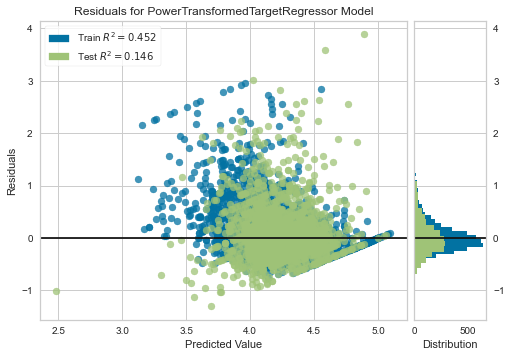

In [35]:
plot_model(catboost_base)

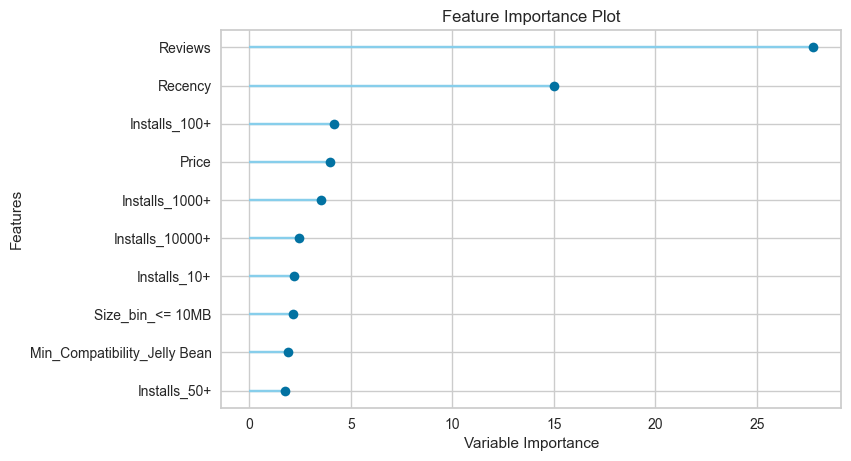

In [36]:
plot_model(catboost_base, plot='feature')

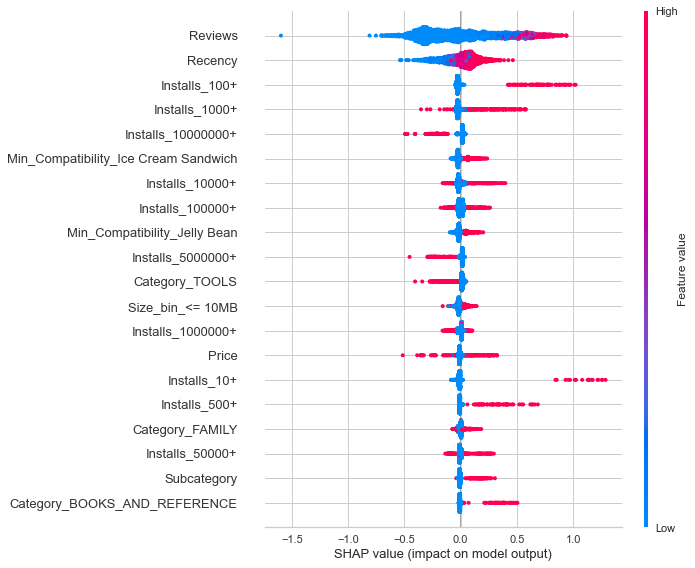

In [41]:
interpret_model(catboost_base)

From the SHAP summary plot, higher number of `Reviews` increase the probability of obtaining higher `Rating`.

In [40]:
predict_model(catboost_base)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,0.3231,0.2431,0.4931,0.1464,0.1113,0.0948


,Reviews,Price,Subcategory,Recency,Category_ART_AND_DESIGN,Category_AUTO_AND_VEHICLES,Category_BOOKS_AND_REFERENCE,Category_BUSINESS,Category_COMICS,Category_COMMUNICATION,...,Min_Compatibility_Jelly Bean,Min_Compatibility_Kit Kat,Min_Compatibility_Lollipop,Min_Compatibility_Marshmallow,Min_Compatibility_None,Min_Compatibility_Nougat,Min_Compatibility_Oreo,Min_Compatibility_Varies with device,Rating,Label
0,1,-0.288891,0,1.068691,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,4.994783
1,102594,-0.288891,0,0.962709,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.6,4.384888
2,4595,-0.288891,0,-0.881332,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.7,4.185448
3,834,-0.288891,0,1.049171,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.9,4.288022
4,62301,-0.288891,0,1.049171,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.2,4.263824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2207,1516,-0.288891,0,1.010465,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.3,4.235652
2208,6,-0.288891,0,-0.429194,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.2,4.764535
2209,16,-0.288891,0,0.497967,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.3,4.236282
2210,14,-0.288891,0,-0.405107,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.3,4.304579


In [50]:
final_catboost = finalize_model(catboost_base)

In [51]:
print(final_catboost)

PowerTransformedTargetRegressor(border_count=254, loss_function='RMSE',
                                power_transformer_method='box-cox',
                                power_transformer_standardize=True,
                                random_state=123,
                                regressor=<catboost.core.CatBoostRegressor object at 0x0000020B281D4048>,
                                task_type='CPU', verbose=False)


### 3.6 Predict on Unseen Data

In [52]:
unseen_pred = predict_model(final_catboost, data=statData_unseen)
unseen_pred.head()

,Category,Rating,Reviews,Installs,Price,Content Rating,Size_bin,Subcategory,Min_Compatibility,Recency,Label
0,SPORTS,4.6,2019,"100,000+",0.0,Everyone,<= 50MB,0,Kit Kat,-164,4.082762
1,FAMILY,4.1,681,"100,000+",0.0,Everyone,<= 50MB,0,Froyo,-1642,3.870171
2,FAMILY,4.2,20,"5,000+",0.0,Everyone,<= 10MB,0,Ice Cream Sandwich,-727,4.179952
3,FAMILY,4.6,498,"50,000+",0.0,Everyone,<= 10MB,0,Ice Cream Sandwich,-442,4.126477
4,MEDICAL,4.7,23160,"1,000,000+",0.0,Everyone,<= 30MB,0,Lollipop,-157,4.395554


In [62]:
unseen_pred[(unseen_pred.Label <= 3.6)]

,Category,Rating,Reviews,Installs,Price,Content Rating,Size_bin,Subcategory,Min_Compatibility,Recency,Label
230,BUSINESS,3.7,3757,"1,000,000+",0.0,Everyone,<= 10MB,0,Gingerbread,-1007,3.529617
326,COMMUNICATION,3.1,497,"100,000+",0.0,Everyone,<= 50MB,0,Kit Kat,-167,3.599316
792,FINANCE,4.8,4,"1,000+",0.0,Everyone,<= 10MB,0,Froyo,-594,3.558580


In [57]:
from pycaret.utils import check_metric
check_metric(unseen_pred.Rating, unseen_pred.Label, 'R2')

0.135

### Conclusion
With R square below 0.15, prediction on unseen data from the model would return ratings that are close to the mean value of Rating from the training data. Another model was attempted by having total installations, `Installs` converted to a numeric variable improved model performance slightly but not significantly (R square below 0.2).

The generalisability of the model is therefore very poor. The existing data points could give rise to preliminary exploratory analysis, but they are not sufficient for modelling purposes. As the variables total no. of `Reviews` and `Recency` are few of the most influential features, additional data points such as duration and frequency of user sessions would likely be able to help boost model performance.